In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,LabelEncoder
from xgboost import XGBRFRegressor,XGBRegressor

In [59]:
df = pd.read_csv('/content/oil_retail_history.csv')

In [60]:
df.head(10)

,date,price,cost,comp1_price,comp2_price,comp3_price,volume
0,2023-01-01,97.66,86.46,98.39,99.10,97.37,13513
1,2023-01-02,96.46,87.25,95.37,96.25,97.38,13605
2,2023-01-03,94.67,86.40,94.41,94.69,94.50,16540
3,2023-01-04,97.32,87.51,99.12,96.90,97.54,14927
4,2023-01-05,94.08,86.38,93.31,94.61,93.85,13332
5,2023-01-06,96.73,88.24,97.27,97.17,97.23,13643
6,2023-01-07,98.63,87.79,98.31,99.22,99.34,13603
7,2023-01-08,100.89,88.00,101.76,101.22,101.35,14638
8,2023-01-09,97.71,88.68,99.49,99.68,97.38,13867
9,2023-01-10,97.14,89.05,96.02,98.24,96.82,13471


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         730 non-null    object 
 1   price        730 non-null    float64
 2   cost         730 non-null    float64
 3   comp1_price  730 non-null    float64
 4   comp2_price  730 non-null    float64
 5   comp3_price  730 non-null    float64
 6   volume       730 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 40.1+ KB


In [62]:
df.describe()

,price,cost,comp1_price,comp2_price,comp3_price,volume
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,96.505301,86.498178,96.551658,96.530068,96.457260,13960.983562
std,2.747598,1.575689,2.779654,2.796763,2.782295,905.912360
min,88.080000,83.340000,88.320000,87.070000,86.080000,11397.000000
25%,94.670000,85.302500,94.555000,94.827500,94.712500,13326.250000
50%,96.525000,86.255000,96.590000,96.430000,96.515000,13882.000000
75%,98.420000,87.610000,98.467500,98.447500,98.097500,14538.750000
max,104.890000,91.860000,104.200000,105.000000,104.360000,16890.000000


In [63]:
df.isnull().sum()

,0
date,0
price,0
cost,0
comp1_price,0
comp2_price,0
comp3_price,0
volume,0


In [64]:
df['price']>=df['cost'].all()

,price
0,True
1,True
2,True
3,True
4,True
...,...
725,True
726,True
727,True
728,True


In [65]:
df['volume']>0

,volume
0,True
1,True
2,True
3,True
4,True
...,...
725,True
726,True
727,True
728,True


In [66]:
df['date'] = pd.to_datetime(df['date'])

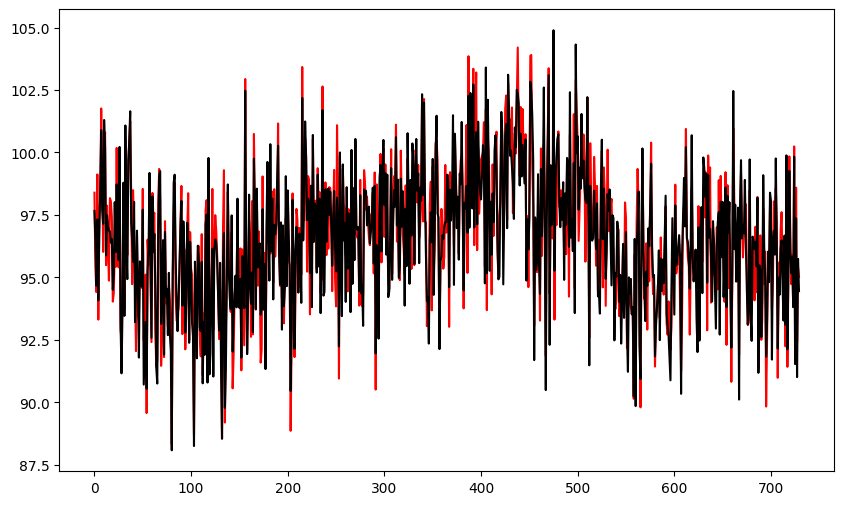

In [67]:
plt.figure(figsize = (10,6))
plt.plot(df['comp1_price'],color = 'red')
plt.plot(df['price'],color = 'black')

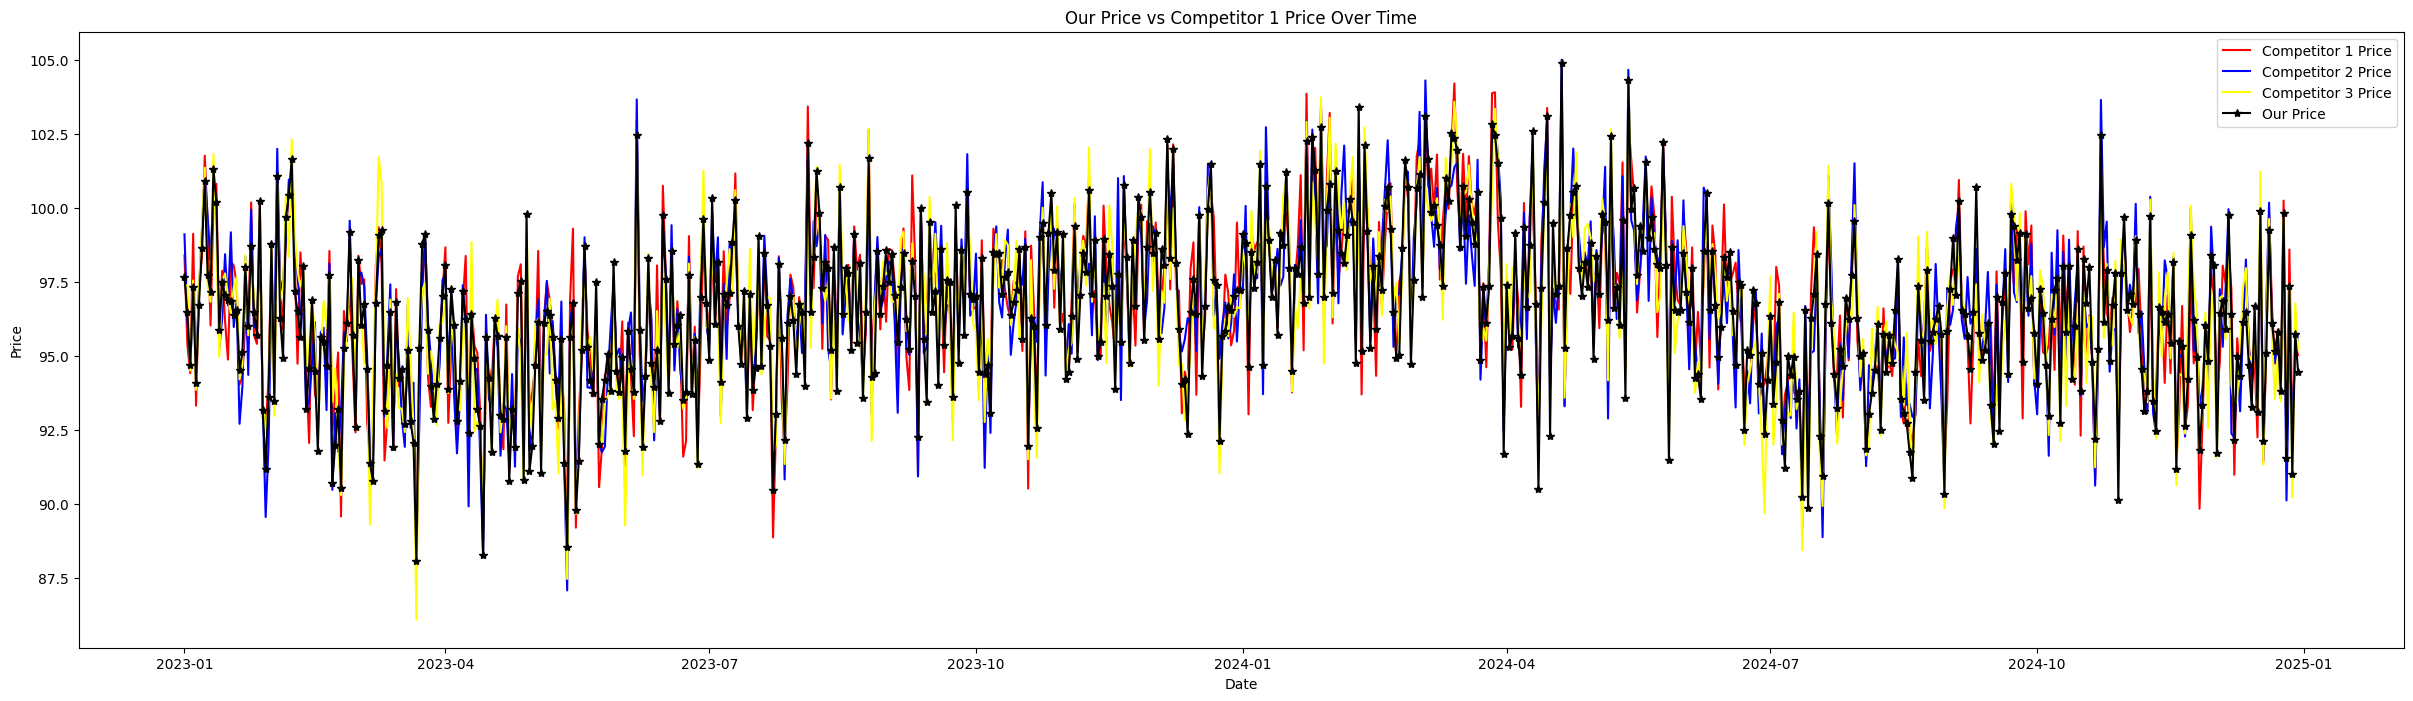

In [68]:
plt.figure(figsize=(30,8))

plt.plot(df['date'], df['comp1_price'], color='red', label='Competitor 1 Price')
plt.plot(df['date'], df['comp2_price'], color='blue', label='Competitor 2 Price')
plt.plot(df['date'], df['comp3_price'], color='yellow', label='Competitor 3 Price')
plt.plot(df['date'], df['price'], color='black', label='Our Price',marker = '*')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Our Price vs Competitor 1 Price Over Time')
plt.legend()
plt.show()


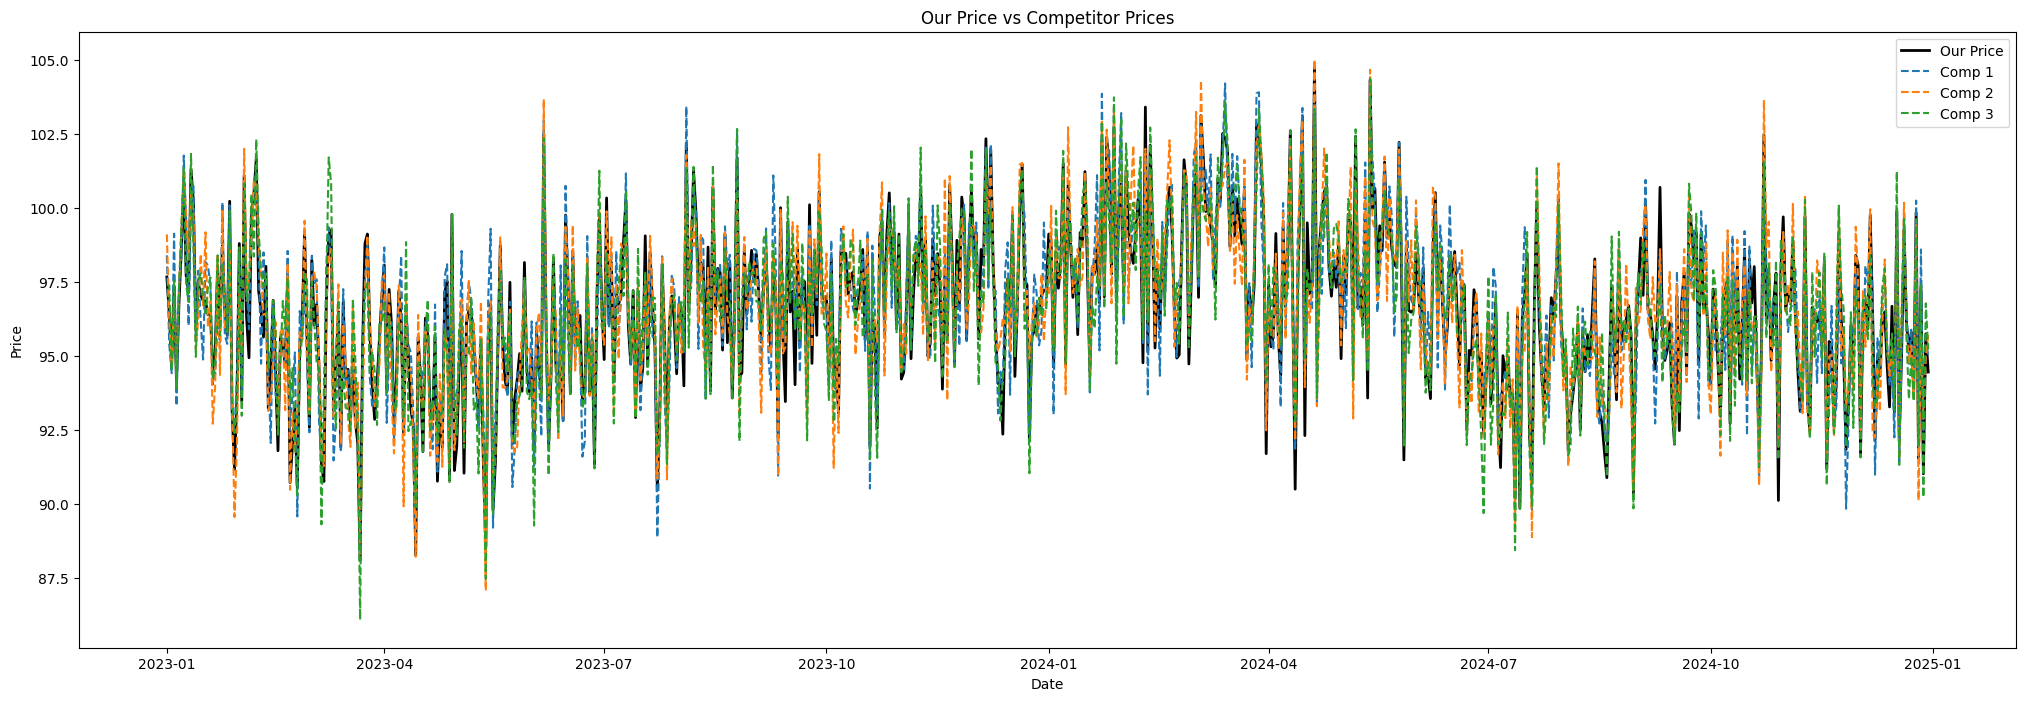

In [69]:
plt.figure(figsize=(25,8))

plt.plot(df['date'], df['price'], color='black', linewidth=2, label='Our Price')
plt.plot(df['date'], df['comp1_price'], linestyle='--', label='Comp 1')
plt.plot(df['date'], df['comp2_price'], linestyle='--', label='Comp 2')
plt.plot(df['date'], df['comp3_price'], linestyle='--', label='Comp 3')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Our Price vs Competitor Prices')
plt.legend()
plt.show()


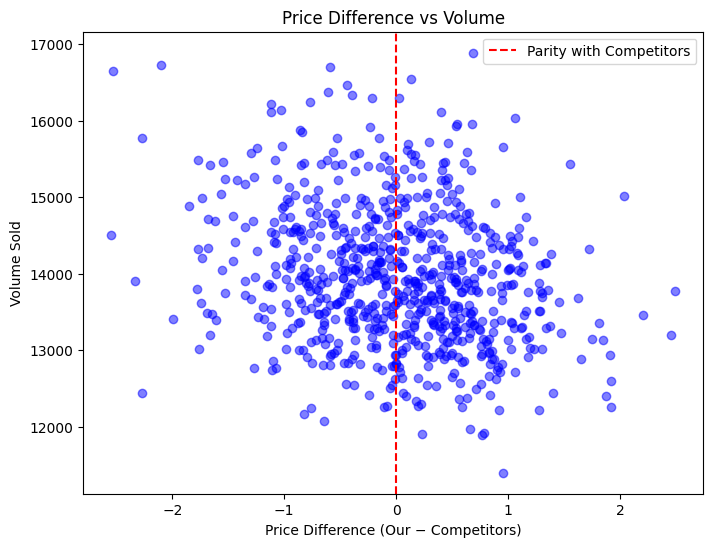

In [70]:
df['avg_comp_price'] = df[['comp1_price','comp2_price','comp3_price']].mean(axis=1)
df['price_diff'] = df['price'] - df['avg_comp_price']
plt.figure(figsize=(8,6))
plt.scatter(
    df['price_diff'],
    df['volume'],
    color='blue',
    alpha=0.5
)

plt.axvline(0, color='red', linestyle='--', label='Parity with Competitors')

plt.xlabel('Price Difference (Our − Competitors)')
plt.ylabel('Volume Sold')
plt.title('Price Difference vs Volume')
plt.legend()
plt.show()


In [71]:
df = df.sort_values("date").reset_index(drop=True)

In [72]:
df['avg_comp_price'] = df[['comp1_price','comp2_price','comp3_price']].mean(axis=1)
df['price_diff'] = df['price'] - df['avg_comp_price']

In [73]:
df['volume_lag_1'] = df['volume'].shift(1)

In [74]:
df['volume_roll_7'] = df['volume'].rolling(7).mean()

In [75]:
df = df.dropna().reset_index(drop=True)

In [76]:
X = df[[
    'price',
    'cost',
    'comp1_price',
    'comp2_price',
    'comp3_price',
    'price_diff',
    'volume_lag_1',
    'volume_roll_7'
]]
y = df['volume']

In [77]:
X_train = X.iloc[:-60]
X_test  = X.iloc[-60:]

y_train = y.iloc[:-60]
y_test  = y.iloc[-60:]

In [78]:
baseline_pred = X_test['volume_roll_7']
baseline_r2 = r2_score(y_test, baseline_pred)
print("Baseline R2:", baseline_r2)

Baseline R2: 0.04029433923572334


In [79]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=200, random_state=42)

In [80]:
rf_pred = rf_model.predict(X_test)

In [81]:
mse = mean_squared_error(y_test, rf_pred)
r2 = r2_score(y_test, rf_pred)

In [82]:
print("RF MSE:", mse)
print("RF R2:", r2)

RF MSE: 951803.0733702925
RF R2: 0.057627595695601275


XGBoost

In [83]:
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [84]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [85]:
xgb_pred = xgb_model.predict(X_test)

In [86]:
print("XGB R2:", r2_score(y_test, xgb_pred))

XGB R2: 0.021525442600250244


In [87]:
importance = pd.Series(
    rf_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(importance)

volume_roll_7    0.211778
volume_lag_1     0.194361
price_diff       0.185780
cost             0.097454
comp2_price      0.091707
comp1_price      0.082198
comp3_price      0.074384
price            0.062338
dtype: float64


In [88]:
import json

last_row = df.iloc[-1]

today_data = {
    "date": str(last_row["date"].date()),
    "last_price": float(last_row["price"]),
    "cost": float(last_row["cost"]),
    "comp1_price": float(last_row["comp1_price"]),
    "comp2_price": float(last_row["comp2_price"]),
    "comp3_price": float(last_row["comp3_price"])
}

with open("data/today.json", "w") as f:
    json.dump(today_data, f, indent=4)


In [89]:
import json

with open("data/today.json") as f:
    today = json.load(f)

In [90]:
import pandas as pd

def build_today_features(today, history_df):
    avg_comp_price = (
        today["comp1_price"] +
        today["comp2_price"] +
        today["comp3_price"]
    ) / 3

    price_diff = today["last_price"] - avg_comp_price

    volume_lag_1 = history_df.iloc[-1]["volume"]
    volume_roll_7 = history_df.iloc[-7:]["volume"].mean()
    dow = pd.to_datetime(today["date"]).dayofweek

    X_today = pd.DataFrame([{
        "price": today["last_price"],   # will be replaced during simulation
        "cost": today["cost"],
        "comp1_price": today["comp1_price"],
        "comp2_price": today["comp2_price"],
        "comp3_price": today["comp3_price"],
        "price_diff": price_diff,
        "volume_lag_1": volume_lag_1,
        "volume_roll_7": volume_roll_7,
        "dow": dow
    }])

    return X_today

In [91]:
from datetime import datetime, timedelta

def update_daily_json(prev_json, new_cost, comp_prices):
    new_date = (
        datetime.strptime(prev_json["date"], "%Y-%m-%d")
        + timedelta(days=1)
    ).strftime("%Y-%m-%d")

    return {
        "date": new_date,
        "last_price": prev_json["last_price"],
        "cost": new_cost,
        "comp1_price": comp_prices[0],
        "comp2_price": comp_prices[1],
        "comp3_price": comp_prices[2]
    }
